In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Import Data Frame and view data
df = pd.read_csv('time_data.csv',sep=',')
df.head()

,time,conv
0,0,0.000000
1,5,3.289106
2,10,6.685466
3,15,9.974572
4,20,12.655909


In [3]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 24
# Specify dimensionality of dataframe
df_dim = 2
# learning rate
lr = 0.002
# number of epoch
num_epochs = 1100
# Discriminator dropout
drop_out=0.3
# Define batch size for the data loader
batch_size = 12

# This part turns the pandas dataframe columns into tensors for the GAN
col1 = df['time'].values
col2 = df['conv'].values

array1 = np.zeros(num_data)
array2 = np.zeros(num_data)
for i in range(num_data):
    array1[i] = col1[i]
    array2[i] = col2[i]

train_data_length = num_data
train_data = torch.zeros((num_data, df_dim))
train_data[:, 0] = torch.from_numpy(array1)
train_data[:, 1] = torch.from_numpy(array2)
train_labels = torch.zeros(num_data)
train_set = [(train_data[i], train_labels[i]) for i in range(num_data)]

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Discriminator and Generator

In [4]:
class Discriminator(nn.Module):
    # Classifies data as real or synthetic, used to train generator
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size*8)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*8), (batch_size*4)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*4), (batch_size*2)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

In [5]:
class Generator(nn.Module):
    # Generates synthetic data
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size)),
            nn.ReLU(),
            nn.Linear((batch_size), (batch_size*2)),
            nn.ReLU(),
            nn.Linear((batch_size*2), df_dim),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [6]:
# loss function
loss_function = nn.BCELoss()
# Optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [7]:
# This is where the generator and discrimator are trained
for epoch in range(num_epochs):

    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, df_dim))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, df_dim))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        # Show loss
#         if epoch % 10 == 0 and n == batch_size - 1:
#             print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
#             print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [8]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [9]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples)
df_gen = df_gen.set_axis(['time','conv'], axis=1, inplace=False)


/tmp/ipykernel_10166/1632469481.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_gen = df_gen.set_axis(['time','conv'], axis=1, inplace=False)


(0.0, 60.0)

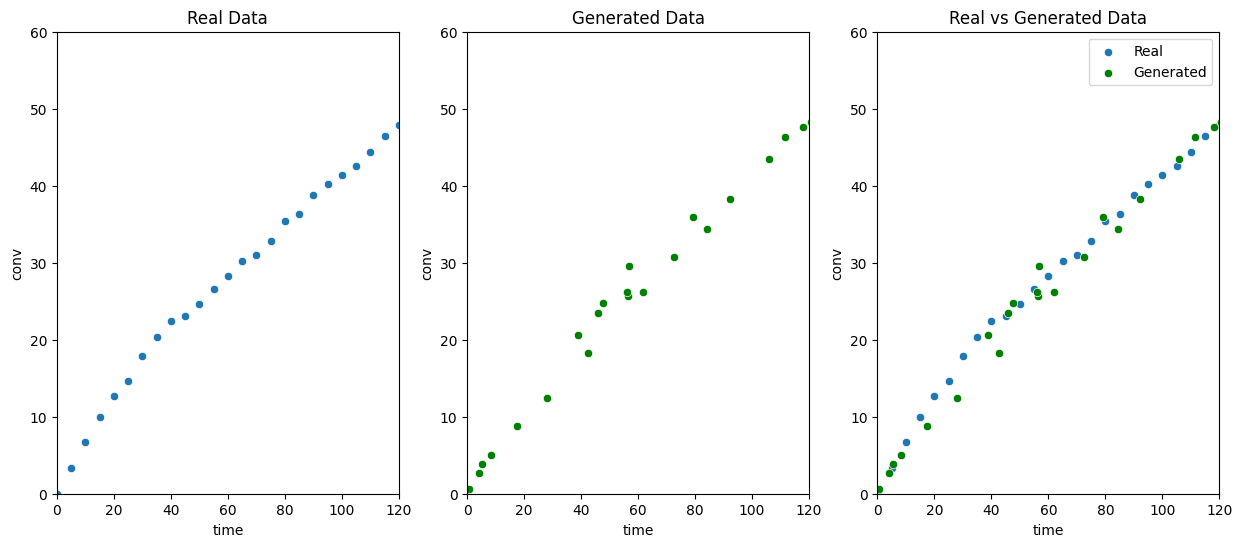

In [10]:
# Plotting Real vs Generated data
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[2].set_title('Real vs Generated Data')
sns.scatterplot(ax=axes[0], data=df, x='time', y='conv')
axes[0].set_title('Real Data')
axes[0].set_xlim(0, 120)
axes[0].set_ylim(0, 60)
sns.scatterplot(ax=axes[1], data=df_gen, x='time', y='conv', color='g')
axes[1].set_title('Generated Data')
axes[1].set_ylim(0, 60)
axes[1].set_xlim(0, 120)
sns.scatterplot(ax=axes[2], data=df, x='time', y='conv', label='Real')
sns.scatterplot(ax=axes[2], data=df_gen, x='time', y='conv', color='g', label= 'Generated')
axes[2].set_title('Real vs Generated Data')
axes[2].set_xlim(0, 120)
axes[2].set_ylim(0, 60)

In [11]:
print('Current Model Parameters:')
print('Size of dataset:', num_data)
print('Number of epochs:', num_epochs)
print('Learning Rate:', lr)
print('Discriminator dropout:', drop_out)
print('Batch Size:', batch_size)

Current Model Parameters:
Size of dataset: 24
Number of epochs: 1100
Learning Rate: 0.002
Discriminator dropout: 0.3
Batch Size: 12
